In [1]:
from sympy import *
import numpy as np
import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap

init_printing() 

In [2]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [3]:
def get_stoich_prop(Eqs_to_solve):
    MatEq = expand(Matrix(Eqs_to_solve))
    pseudo_prof = []
    done = set()
    for x in MatEq:
        for y in x.args:
            number = [ atom for atom in y.atoms() if atom.is_number ]
            if number:
                key = y/number[0]
                if key not in done:
                    pseudo_prof.append(key)
                    done.add(key)
            else:
                if y not in done:
                    pseudo_prof.append(y)
                    done.add(y)

    row_len = len(Eqs_to_solve)
    col_len = len(pseudo_prof)

    Sp_stoich = np.zeros((row_len, col_len))
    for i in range(row_len):
        expanded_mat = expand(MatEq[i])
        for j in range(col_len):
            for atom in expanded_mat.args:
                key = atom/pseudo_prof[j]
                if key.is_number:
                    Sp_stoich[i,j] = key
                    break
    return Matrix(Sp_stoich), Matrix(pseudo_prof)

In [4]:
t = Symbol('t', real = True, nonnegative=True)
A, B, C, D = symbols('A, B, C, D', real=True, positive=True)  
k1, k2, k3, k4, k5, k6 = symbols('k1, k2, k3, k4, k5, k6',real=True,positive=True)
reactions = [k1, k2, k3, k4, k5, k6]
components = [A, B, C, D]

In [5]:
Stoich_mat = Matrix([
    [1, -1,  0,  0,  1,  0], #a
    [0,  1, -1,  0,  0,  0], #b
    [0,  0,  1, -1,  0, -1], #c
    [0,  0,  0,  1, -1,  0]  #d
])

In [6]:
Prop_vec  = Matrix([
    k1,
    k2*A,
    k3*B,
    k4*C,
    k5*D,
    k6*C
]) 

In [7]:
dX_dt = Stoich_mat*Prop_vec

In [8]:
Aj = dX_dt.jacobian(components)

In [9]:
Prop_vec_F = diag(*Prop_vec )

In [10]:
BBT = Stoich_mat*Prop_vec_F*Stoich_mat.T

In [11]:
Cov = Matrix([ 
    [var("C_"+str(components[i])+str(components[j])) for j in range(len(components))] for i in range(len(components)) 
])

dsub = []
for i in range(len(components)):
    for j in range(i,len(components)):
        Cov[j,i] = Cov[i,j]
        if i != j:
            dsub.append((Cov[j,i],0))

In [12]:
dCov_dt = Aj*Cov + Cov*Aj.T + BBT 

In [13]:
Eqs_to_solve = []
ccm_components = []
ss_symbols = []

for i in range(dCov_dt.shape[0]):
    for j in range(i,dCov_dt.shape[0]):
        if i == j:                                             ###### Covariance not included
            Eqs_to_solve.append(dCov_dt[i,j].subs(dsub))
            ccm_components.append(Cov[i,j])
            ss_symbols.append(Eq(Cov[i,j].diff(t), dCov_dt[i,j].subs(dsub)))
        
for i in range(dX_dt.shape[0]):
    Eqs_to_solve.append(dX_dt[i])
    ccm_components.append(components[i])
    ss_symbols.append(Eq(components[i].diff(t), dX_dt[i]))

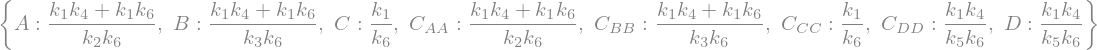

In [14]:
simplify(solve(ss_symbols,ccm_components))

In [15]:
ccm_components = Matrix(ccm_components)

In [16]:
Sp_stoich, fp_Prop = get_stoich_prop(Eqs_to_solve)

In [17]:
fp_Prop = Matrix([ eval(str(x)) for x in fp_Prop ])

In [18]:
kerV = Matrix(Sp_stoich.nullspace(0))

In [19]:
kerV.shape

In [20]:
kerV = kerV.reshape(int(len(kerV)/len(fp_Prop)),len(fp_Prop))

In [21]:
Aj = fp_Prop.jacobian(ccm_components)

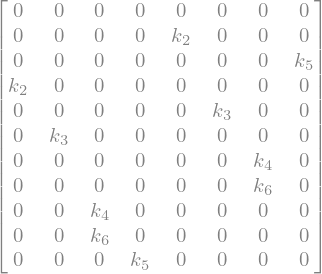

In [22]:
Aj

In [23]:
Aj = Aj.col_insert(Aj.shape[1],-kerV.T)

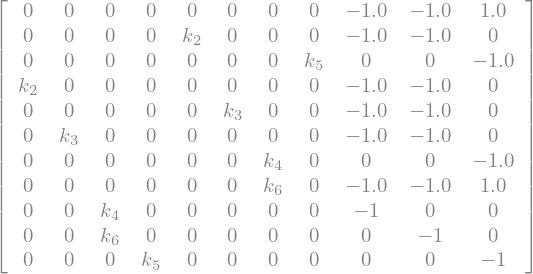

In [24]:
Aj

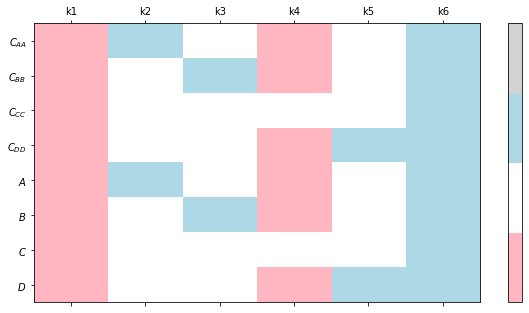

In [25]:
Jfp = fp_Prop.jacobian(reactions).T

Sprime = simplify(Aj.inv())
Nans = Matrix(Sprime)

ans = Matrix([])
for i in range(len(reactions)):
    col = None
    for j in range(Jfp.shape[1]):
        if Jfp[i,j] != 0:
            if col is None:
                col = simplify(Nans[:,j])
            else:
                col = col + simplify(Nans[:,j])
    ans = ans.col_insert(ans.shape[1],col)

for i in range(ans.shape[0]):
    for j in range(ans.shape[1]):
        v = ans[i,j]
        try:
            if ans[i,j]>0:
                ans[i,j] = 1
            elif ans[i,j]<0:
                ans[i,j] = -1
            elif ans[i,j] == 0:
                ans[i,j] = 0
        except:
            ans[i,j] = 2      
            
col = []
for i in range(ans.shape[0]):
    try:
        col.append("$"+str(ccm_components[i]).replace("_","_{")+"}"+"$")
    except:
        pass
    
label_list = [ "$"+str(x).replace("k","k_{")+"}"+"$" for x in reactions ]
    
plt.figure(figsize=(10,5))
plt.matshow(np.array(ans[0:len(col),:],dtype=float),fignum=1,interpolation=None,vmin=-1,aspect="auto",vmax=2,cmap=ListedColormap(['lightpink', 'white','lightblue','lightgrey']))
plt.xticks(ticks=range(len(reactions)),labels=[ str(x) for x in reactions ])
plt.yticks(ticks=range(len(col)),labels=col)
plt.colorbar(ticks=[])
plt.show()
plt.close()

In [26]:
res = simplify(solve(ss_symbols,ccm_components))

In [27]:
ss_vals = [
    (A, res[A]),
    (B, res[B]),
    (C, res[C]),
    (D, res[D]),
    (Cov[0,0], res[Cov[0,0]]),
    (Cov[1,1], res[Cov[1,1]]),
    (Cov[2,2], res[Cov[2,2]]),
    (Cov[3,3], res[Cov[3,3]])
]

In [28]:
##### step 10 #####

H = Matrix([   
    [ fp_Prop[i].diff(reactions[j])*reactions[j] for j in range(len(reactions)) ]
    for i in range(len(fp_Prop))
])

Nans = simplify(Sprime*H.subs(ss_vals))

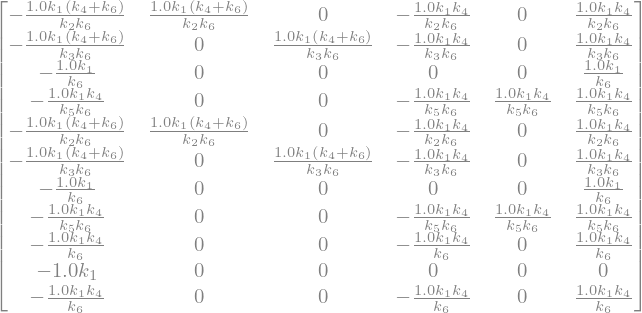

In [29]:
Nans

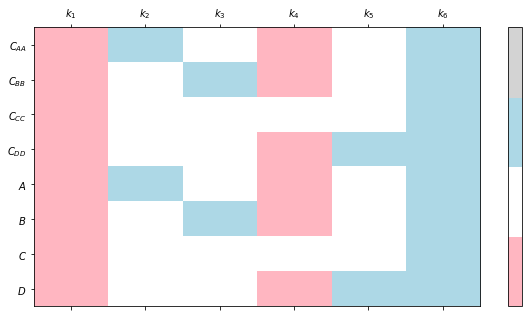

In [30]:
ans = np.zeros(Nans.shape)

for i in range(ans.shape[0]):
    for j in range(ans.shape[1]):
        V = Nans[i,j]
        try:
            if V>0:
                ans[i,j] = 1
            elif V<0:
                ans[i,j] = -1
            elif V == 0:
                ans[i,j] = 0
        except:
            ans[i,j] = 2      
            
col = []
for i in range(ans.shape[0]):
    try:
        col.append("$"+str(ccm_components[i]).replace("_","_{")+"}"+"$")
    except:
        pass
    
label_list = [ "$"+str(x).replace("k","k_{")+"}"+"$" for x in reactions ]
    
plt.figure(figsize=(10,5))
plt.matshow(np.array(ans[0:len(col),:],dtype=float),fignum=1,interpolation=None,vmin=-1,aspect="auto",vmax=2,cmap=ListedColormap(['lightpink', 'white','lightblue','lightgrey']))
plt.xticks(ticks=range(len(reactions)),labels=label_list)
plt.yticks(ticks=range(len(col)),labels=col)
plt.colorbar(ticks=[])
plt.show()
plt.close()